In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(rc={'figure.figsize': [8, 5]}, font_scale=1.2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
x_train = pd.read_csv('datasets/car_data/train_data.csv')
y_train = pd.read_csv('datasets/car_data/train_labels.csv')

x_val = pd.read_csv('datasets/car_data/val_data.csv')
y_val = pd.read_csv('datasets/car_data/val_labels.csv')

x_test = pd.read_csv('datasets/car_data/test_data.csv')
y_test = pd.read_csv('datasets/car_data/test_labels.csv')

In [4]:
print('Data Len: ',len(x_train),'  Label Len: ',len(y_train))

Data Len:  192   Label Len:  192


In [5]:
# === merge 2 dataframes 'data' and 'labels' ===
cars_df = pd.concat([x_train, y_train],axis=1)

In [6]:
cars_df

,horsepower,weight,cylinders,displacement,mpg
0,115.000,2595,6,173.000,28.800
1,180.000,4380,8,350.000,16.500
2,150.000,4457,8,318.000,14.000
3,105.000,3897,6,250.000,16.000
4,193.000,4732,8,304.000,9.000
...,...,...,...,...,...
187,95.000,3193,6,258.000,17.500
188,110.000,3520,6,250.000,17.500
189,92.000,2620,4,156.000,25.800
190,80.000,1915,4,98.000,35.700


## Data Exploration

In [7]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   horsepower    192 non-null    float64
 1   weight        192 non-null    int64  
 2   cylinders     192 non-null    int64  
 3   displacement  192 non-null    float64
 4   mpg           192 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 7.6 KB


In [8]:
cars_df.describe()

,horsepower,weight,cylinders,displacement,mpg
count,192.000,192.000,192.000,192.000,192.000
mean,107.932,3021.396,5.589,202.677,23.481
std,40.509,877.626,1.779,109.448,8.253
min,46.000,1795.000,3.000,70.000,9.000
25%,78.000,2229.000,4.000,105.000,16.000
50%,96.500,2803.500,4.500,153.000,22.000
75%,140.000,3765.000,8.000,304.000,30.000
max,230.000,5140.000,8.000,455.000,46.600


In [9]:
cars_df.isnull().sum()

horsepower      0
weight          0
cylinders       0
displacement    0
mpg             0
dtype: int64

## Data Analysis
> ### Univariate Anlaysis
> ### Numeric attributes
> #### horsepower, weight, cylinders, displacement, mpg
>> ##### Check distribution and outliers in all numeric attributes

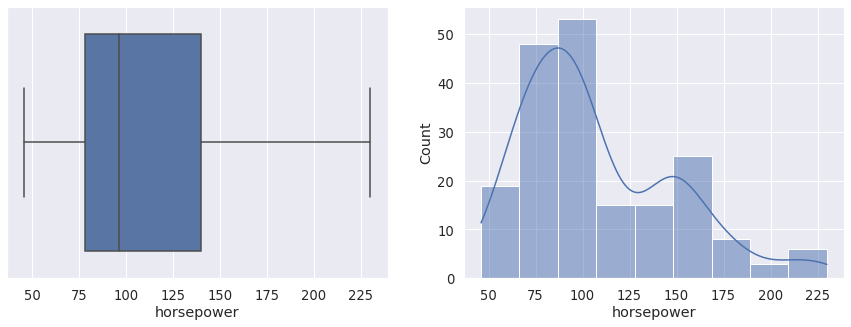

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cars_df["horsepower"], ax=axes[0])
sns.histplot(data=cars_df, x="horsepower", kde=True, ax=axes[1]);

- 75% below 150 horsepower
- Most frequence in 100 and 75 horsepower

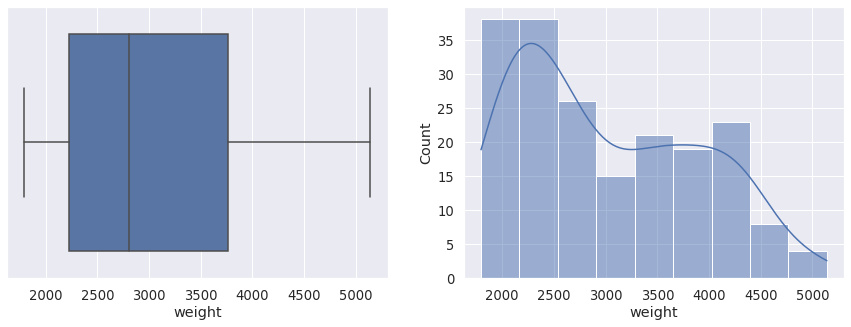

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cars_df["weight"], ax=axes[0])
sns.histplot(data=cars_df, x="weight", kde=True, ax=axes[1]);

- 50% below 3000, 75% below 4000

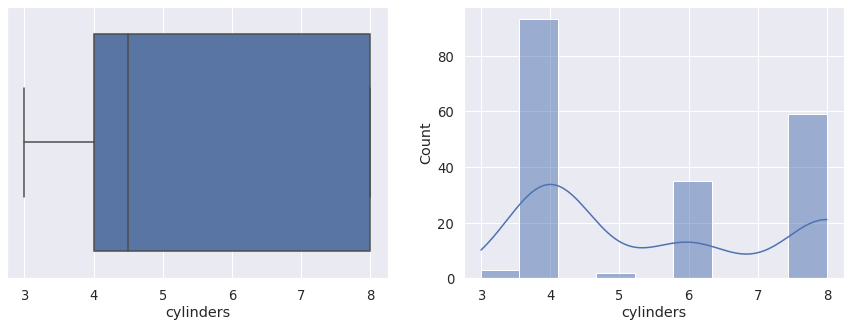

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cars_df["cylinders"], ax=axes[0])
sns.histplot(data=cars_df, x="cylinders", kde=True, ax=axes[1]);

- Most frequency no of cylinders are 4, 50% has 3 and 4 cylinders
- Other 50% has 8, 6, 5 cylinders
- Top 3 frequencies are 4, 8 and 6

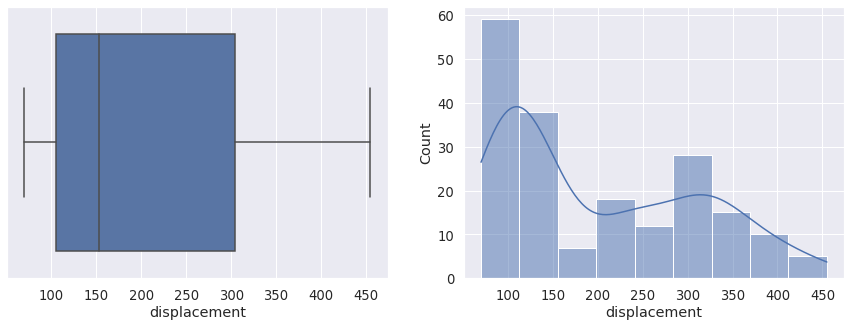

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cars_df["displacement"], ax=axes[0])
sns.histplot(data=cars_df, x="displacement", kde=True, ax=axes[1]);

- 50% till 150 displacement

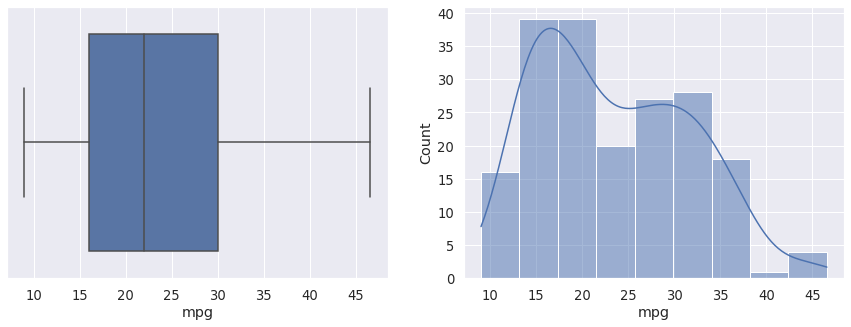

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
sns.boxplot(cars_df["mpg"], ax=axes[0])
sns.histplot(data=cars_df, x="mpg", kde=True, ax=axes[1]);

- 75% below 30 mpg
- Most frequency from 15 till 20 mpg

> ### Bivariate and Multivariate Anlaysis

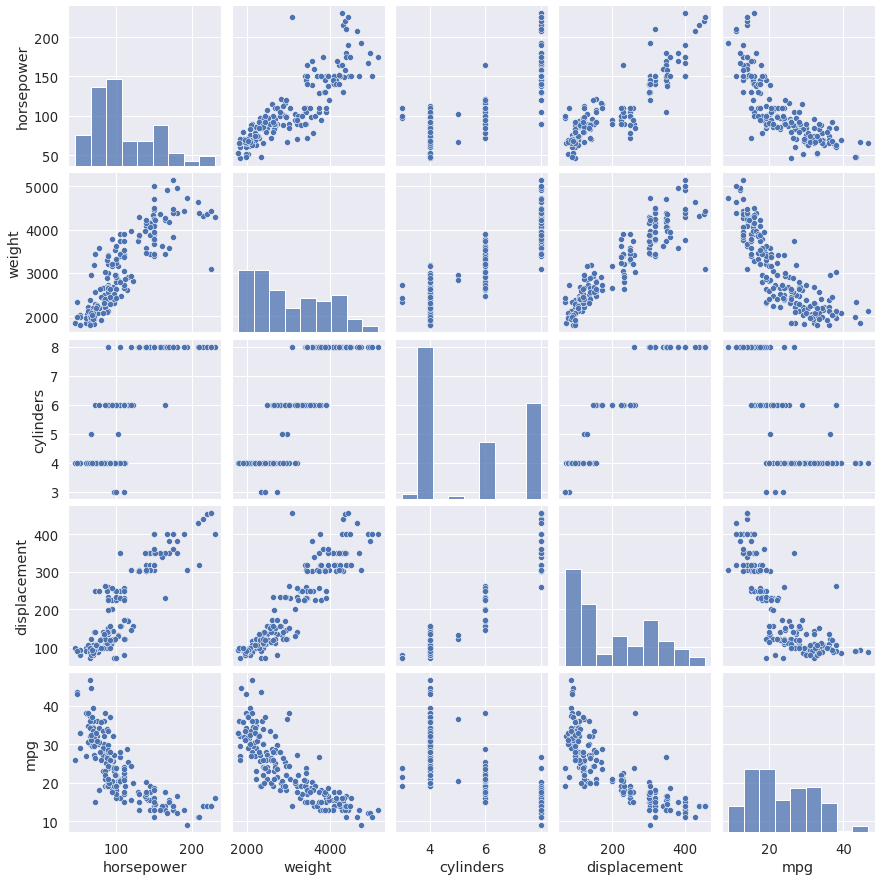

In [15]:
sns.pairplot(cars_df);

- <b>Increasing in horsepower, weight and cylinders with decreasing in mpg</b>
- So increasing in all independent features refelecting on decreasing on dependent feature "mpg" 

## Data Preprocessing 

In [16]:
cp_df=cars_df.copy()

> ### Duplicated Values

In [17]:
cp_df[cp_df.duplicated()]

,horsepower,weight,cylinders,displacement,mpg
132,53.000,1795,4,91.000,33.000


In [18]:
cp_df.drop_duplicates(inplace=True)

In [19]:
cp_df[cp_df.duplicated()]

,horsepower,weight,cylinders,displacement,mpg


> ### Correlation 

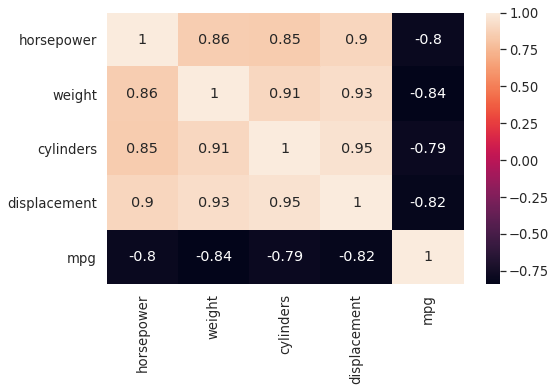

In [20]:
sns.heatmap(cp_df.corr(), annot=True);

- <b> Multicollinearity issue </b>, all independent features have strong positive correlaction with each other

In [21]:
#=== Check VIF ===
def get_vif_df(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

In [22]:
get_vif_df(cp_df)

,Feature,VIF
0,horsepower,40.139
1,weight,78.011
2,cylinders,113.166
3,displacement,69.180
4,mpg,9.317


- cylinders has the highest VIF score

In [23]:
cp_df.drop(['cylinders'], axis=1, inplace=True)

In [24]:
cp_df.columns

Index(['horsepower', 'weight', 'displacement', 'mpg'], dtype='object')

In [25]:
get_vif_df(cp_df)

,Feature,VIF
0,horsepower,40.133
1,weight,61.424
2,displacement,41.735
3,mpg,6.757


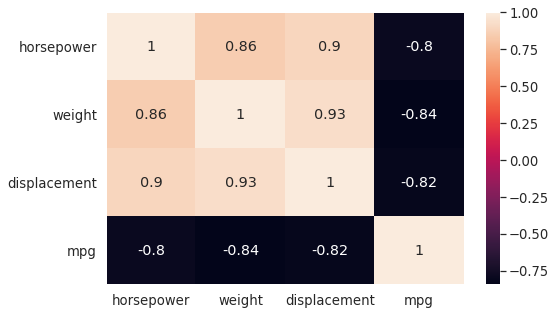

In [26]:
sns.heatmap(cp_df.corr(), annot=True);

- There is still multicollinearity between independent variables, we should remove features with VIF score above 10 but all features are higher than 10, so we removed "cylinders" which has the highest VIF "113.166"

In [27]:
x_val.drop(['cylinders'], axis=1, inplace=True)
x_test.drop(['cylinders'], axis=1, inplace=True)

> ### Spliting Data

In [28]:
cols = list(cp_df.columns)
cols.remove('mpg')

def spliting_data(cp_df):
    x_train = cp_df.loc[:,cols]
    y_train = cp_df.loc[:,'mpg']
    return x_train, y_train

x_train, y_train = spliting_data(cp_df)

> ### Feature Scaling

In [29]:
def scaling_data(X):
    scaler = StandardScaler().fit(X)
    x_scaled = scaler.transform(X)
    return x_scaled

x_scale_train = scaling_data(x_train)
x_scale_val = scaling_data(x_val)
x_scale_test = scaling_data(x_test)

### Building Models

In [30]:
# === Ploting regression line between test and prediction ===
def plt_reg(y_val, y_pred, label):
    plt.figure()
    sns.regplot(x=y_pred, y=y_val).set(title='Regression plot of '+str(label)+' and Prediction')
    
# === Fitting, predicting ===
def eval_model(x_train, x_val, y_val, model, label):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    n = len(y_pred)
    k = len(cols)+1
    print('Training R^2 score:  ', model.score(x_train, y_train))
    print( str(label)+' R^2 score:', model.score(x_val, y_val))
    print('Adj R^2 score:       ', 1 - (1-metrics.r2_score(y_val, y_pred)) * (n-1)/(n-k-1))
    print('MSE score:           ', metrics.mean_squared_error(y_val, y_pred))
    return y_val, y_pred, model

# === Ploting polynomial degree and its MSE also display degree with accuracy score for cross-validation ===
def plt_data(x, y, label, ax=False):
    if ax: ax.plot(x, y)  
    else:
        plt.plot(x, y)
        plt.title('Polynomial Regression')
        plt.xlabel('Degree')
        plt.ylabel(label)

# === Tunning manually with different degrees  === 
def tunning_poly_reg(x_train, x_val, y_val, max_range, label):
    x_lst=[]
    y_lst=[]
    for i in range(1, max_range):
        print('Degree ==>> ',i)
        x_lst.append(i)    
        poly = PolynomialFeatures(degree=i)
        x_poly_train = poly.fit_transform(x_train)
        x_poly_val = poly.fit_transform(x_val)
        model = LinearRegression()
        y_val, y_pred ,model = eval_model(x_poly_train, x_poly_val, y_val, model, label)
        y_lst.append(round(metrics.mean_squared_error(y_val, y_pred), 3))
        print('\n')
        plt_reg(y_val, y_pred, 'Validation')
    return x_lst, y_lst

> ### Polynomial Regression

In [31]:
# ==== Get P-values of Independent Features ====
model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
predictions = model.predict(sm.add_constant(x_train))
model.pvalues

const          0.000
horsepower     0.002
weight         0.000
displacement   0.852
dtype: float64

In [32]:
# ==== Remove non-significant feature "displacement" ===
x_scale_train = x_scale_train[:,:2]
x_scale_val = x_scale_val[:,:2]
x_scale_test = x_scale_test[:,:2]

x_train = x_train.loc[:,['horsepower','weight']]
x_val = x_val.loc[:,['horsepower','weight']]
x_test = x_test.loc[:,['horsepower','weight']]

cols = ['horsepower','weight']

Degree ==>>  1
Training R^2 score:   0.7328773337774918
Validation R^2 score: 0.6547640925181009
Adj R^2 score:        0.6439754704092915
MSE score:            19.760317350512143


Degree ==>>  2
Training R^2 score:   0.7826890883426444
Validation R^2 score: 0.6872955868287574
Adj R^2 score:        0.677523573917156
MSE score:            17.89830752611791


Degree ==>>  3
Training R^2 score:   0.7854395552002136
Validation R^2 score: 0.6762279416679007
Adj R^2 score:        0.6661100648450227
MSE score:            18.53178792593077


Degree ==>>  4
Training R^2 score:   0.8002225985199914
Validation R^2 score: 0.45290730809554325
Adj R^2 score:        0.435810661473529
MSE score:            31.31402318788303


Degree ==>>  5
Training R^2 score:   0.812400807099581
Validation R^2 score: 0.3652761373818566
Adj R^2 score:        0.34544101667503957
MSE score:            36.329781124910895


Degree ==>>  6
Training R^2 score:   0.5500779398257567
Validation R^2 score: -0.8156237335993519
A

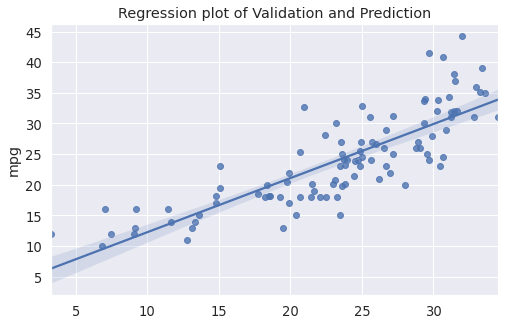

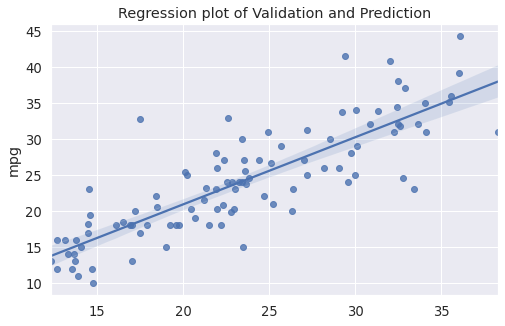

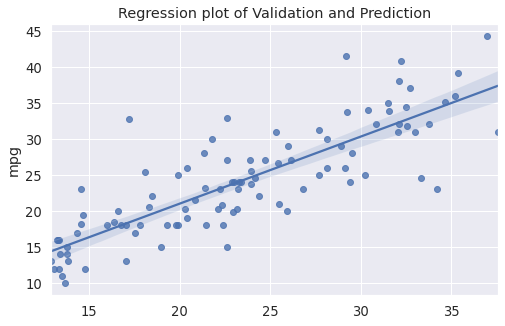

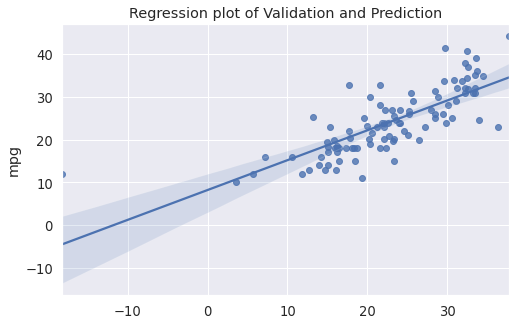

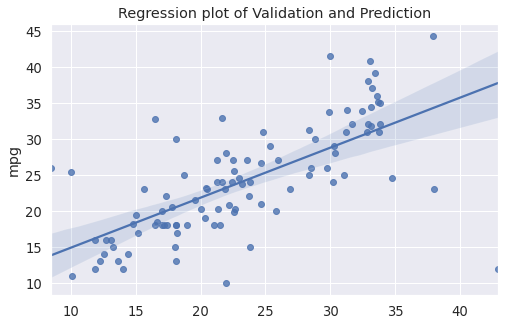

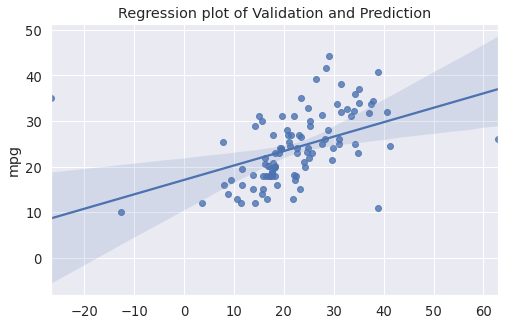

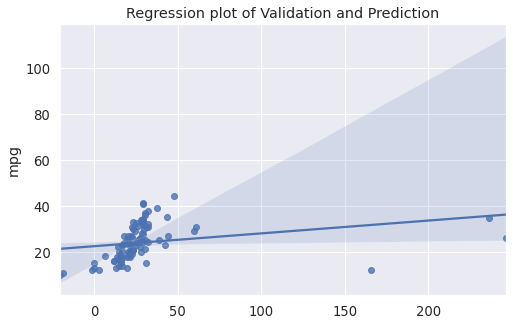

In [33]:
# === Polynomial dergree from 1 to 7, as 1 equal to linear Regression ===
x_scale, y_scale = tunning_poly_reg(x_scale_train, x_scale_val, y_val, 8, 'Validation')

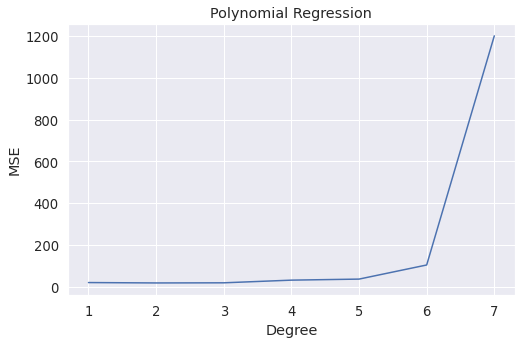

In [34]:
# === MSE from degree 1 till 7 ===
plt_data(x_scale, y_scale, 'MSE')

- Second degree has the best R^2 in both training and validation, we can using regulization for the second degree for more generalization as there is a difference between training and validation scores
- Adj R^2 score: 0.677

In [35]:
# === Polynomial with second degree ===
# === Ridge using different "alpha" ===
for i in range(0, 50, 10):
    print('Alpha ===>>  ', i)
    poly = PolynomialFeatures(degree=2)
    x_poly_train = poly.fit_transform(x_scale_train)
    x_poly_val = poly.fit_transform(x_scale_val)
    ridge_model = Ridge(alpha=i)
    y_val, y_pred ,model = eval_model(x_poly_train, x_poly_val, y_val, ridge_model, 'Validation')
    print('\n')

Alpha ===>>   0
Training R^2 score:   0.7826890883426444
Validation R^2 score: 0.6872955868287574
Adj R^2 score:        0.677523573917156
MSE score:            17.89830752611791


Alpha ===>>   10
Training R^2 score:   0.7809023733972833
Validation R^2 score: 0.6972425816357881
Adj R^2 score:        0.6877814123119065
MSE score:            17.328969951980643


Alpha ===>>   20
Training R^2 score:   0.7772622646552069
Validation R^2 score: 0.7011828185953131
Adj R^2 score:        0.6918447816764166
MSE score:            17.103442041734194


Alpha ===>>   30
Training R^2 score:   0.7723004435851211
Validation R^2 score: 0.7022714216810699
Adj R^2 score:        0.6929674036086033
MSE score:            17.041133510155884


Alpha ===>>   40
Training R^2 score:   0.7663137393521059
Validation R^2 score: 0.7014078811186331
Adj R^2 score:        0.6920768774035904
MSE score:            17.09056010567792




- Alpha with "30" get the best Adj R^2 score "0.69296"

In [36]:
# === Polynomial with second degree ===
#=== Lasso ===
for i in range(1, 5):
    print('Alpha ===>>  ', i)
    poly = PolynomialFeatures(degree=2)
    x_poly_train = poly.fit_transform(x_scale_train)
    x_poly_val = poly.fit_transform(x_scale_val)
    lasso_model = Lasso(alpha=i)
    y_val, y_pred ,model = eval_model(x_poly_train, x_poly_val, y_val, lasso_model, 'Validation')
    print('\n')

Alpha ===>>   1
Training R^2 score:   0.7169394287775767
Validation R^2 score: 0.6667099422291995
Adj R^2 score:        0.656294627923862
MSE score:            19.076571030395627


Alpha ===>>   2
Training R^2 score:   0.6691169782811108
Validation R^2 score: 0.6409132552536825
Adj R^2 score:        0.6296917944803602
MSE score:            20.553099717536224


Alpha ===>>   3
Training R^2 score:   0.5894086444536256
Validation R^2 score: 0.5773664009139823
Adj R^2 score:        0.5641591009425442
MSE score:            24.190340170124664


Alpha ===>>   4
Training R^2 score:   0.47781487124200717
Validation R^2 score: 0.47606922025135046
Adj R^2 score:        0.45969638338420515
MSE score:            29.988301486505744




- The best is polynomial with second degree using Ridge for regulization with alpha "30"

#### Testing 

In [37]:
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_scale_train)
x_poly_test = poly.fit_transform(x_scale_test)

ridge_model = Ridge(alpha=30)
y_test, y_pred ,model = eval_model(x_poly_train, x_poly_test, y_test, ridge_model, 'Testing')

Training R^2 score:   0.7723004435851211
Testing R^2 score: 0.720960197335929
Adj R^2 score:        0.7122402035026767
MSE score:            13.917315531165304


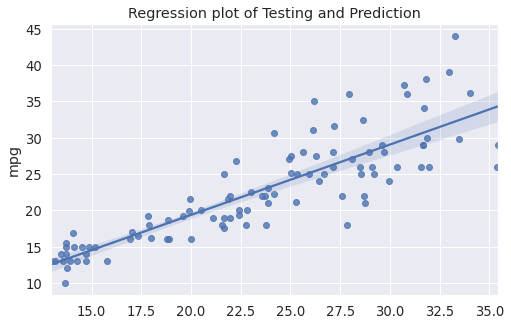

In [38]:
plt_reg(y_test, y_pred, 'Testing')

<b>---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------<b/>

<h3>Questions:</h3>

<b>1- Which polynomial degree gave the best generalization on the test set
based on your observations on the validation set? Are there several
polynomial degrees giving the same results?</b>

The sceond polynomial degree has the best results for both training and testing<br/>
Training R^2 score   = 0.7826890883426444<br/>
Validation R^2 score = 0.6872955868287574<br/>
Adj R^2 score        = 0.677523573917156<br/>
Validation MSE score = 17.89830752611791<br/>

Second and third polynomial degrees scores similar to each other but not the same<br/> 

<table>
    <thead>
        <tr>
            <th></th>
            <th>Second</th>
            <th>Third </th>
         </tr>
    </thead> 
    <tbody>
        <tr>
            <td>Training R^2 score:</td>
            <td>0.7826890883426444</td>
            <td>0.7854395552002136</td>
        </tr> 
        <tr>
            <td>Validation R^2 score:</td>
            <td>0.6872955868287574</td>
            <td>0.6762279416679007</td>
        </tr> 
        <tr>
            <td>Adj R^2 score:</td>
            <td>0.677523573917156</td>
            <td>0.6661100648450227</td>
        </tr>
        <tr>
            <td>Validation MSE score:</td>
            <td>17.89830752611791</td>
            <td>18.53178792593077</td>
        </tr>
    </tbody>
</table>

--------------------------------------------------------------------------------------------------------------

<b>2- Why going up in the degree of polynomial results in making mean
square error closer to 0? Give your technical justification.<br/>

In [39]:
error_scale_df = pd.DataFrame(y_scale, x_scale, columns=['MSE (Scaling)'])
error_scale_df

,MSE (Scaling)
1,19.760
2,17.898
3,18.532
4,31.314
5,36.330
6,103.921
7,1201.401


- MSE descreased till only the second degree then it is increased by increasing degrees

--------------------------------------------------------------------------------------------------------------

<b>3- Try the whole thing once with feature scaling and once without and show the difference in the results with recording your observations and use the best from both in the following problems<br/>

Degree ==>>  1
Training R^2 score:   0.7328773337774919
Validation R^2 score: 0.6658227491315222
Adj R^2 score:        0.6553797100418823
MSE score:            19.127351429483195


Degree ==>>  2
Training R^2 score:   0.7826890883426445
Validation R^2 score: 0.6942314346006369
Adj R^2 score:        0.6846761669319068
MSE score:            17.501319408436764


Degree ==>>  3
Training R^2 score:   0.7854395552002078
Validation R^2 score: 0.6850181006130666
Adj R^2 score:        0.6751749162572249
MSE score:            18.028664332603423


Degree ==>>  4
Training R^2 score:   0.8002150352086255
Validation R^2 score: 0.6437239573970133
Adj R^2 score:        0.63259033106567
MSE score:            20.39222315421729


Degree ==>>  5
Training R^2 score:   0.7997381342623278
Validation R^2 score: 0.6389921924053004
Adj R^2 score:        0.6277106984179659
MSE score:            20.663055868422116


Degree ==>>  6
Training R^2 score:   0.8016416932362378
Validation R^2 score: 0.6530032996374042
A

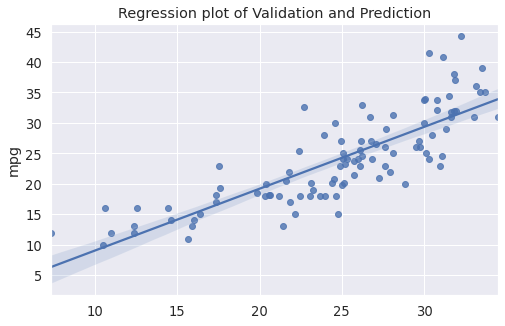

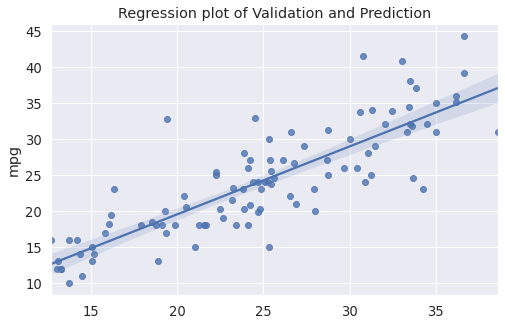

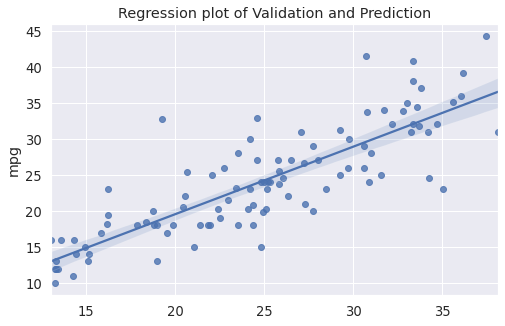

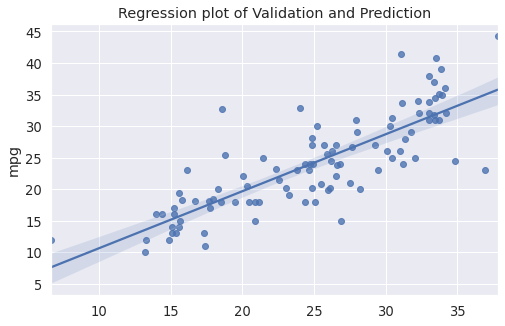

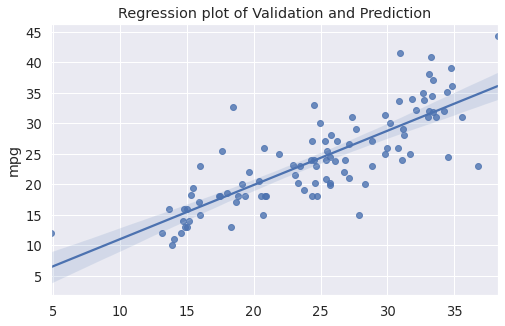

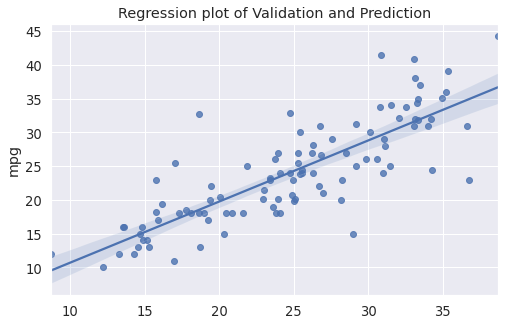

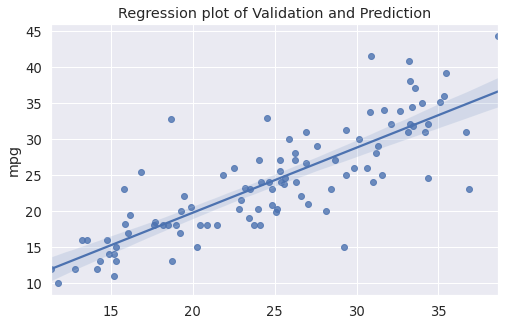

In [40]:
# === Without Scaling ===
# === Polynomial dergree from 1 to 7, as 1 equal to linear Regression ===
x_lst, y_lst = tunning_poly_reg(x_train, x_val, y_val, 8, 'Validation')

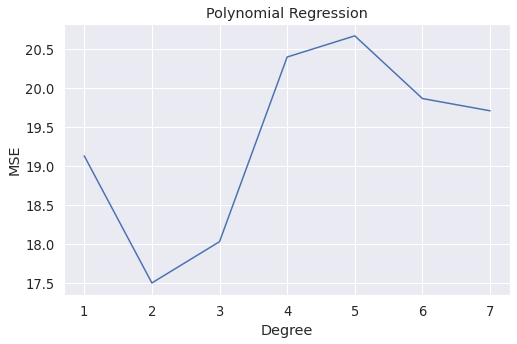

In [41]:
plt_data(x_lst, y_lst, 'MSE')

In [42]:
error_df = pd.DataFrame(y_lst, x_lst, columns=['MSE (Without Scaling)'])
error_df

,MSE (Without Scaling)
1,19.127
2,17.501
3,18.029
4,20.392
5,20.663
6,19.861
7,19.704


> #### Comparing Error between using scaling and without

In [43]:
c_error_df = pd.concat([error_scale_df, error_df],axis=1)
c_error_df

,MSE (Scaling),MSE (Without Scaling)
1,19.760,19.127
2,17.898,17.501
3,18.532,18.029
4,31.314,20.392
5,36.330,20.663
6,103.921,19.861
7,1201.401,19.704


- Big difference in MSE in the higher degrees specially sixth and seventh degrees, but still second degree has the lowest MSE, but without scaling has lower error

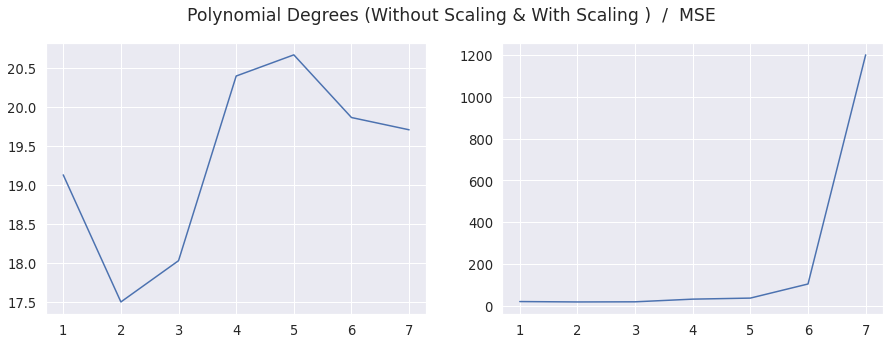

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
fig.suptitle('Polynomial Degrees (Without Scaling & With Scaling )  /  MSE')
plt_data(x_scale, y_scale, 'MSE', ax=axes[1])
plt_data(x_lst, y_lst, 'MSE', ax=axes[0])

In [45]:
# ==== using Ridge with same best alpha "30" ====
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_train)
x_poly_val = poly.fit_transform(x_val)
ridge_model = Ridge(alpha=30)
y_val, y_pred ,r_model = eval_model(x_poly_train, x_poly_val, y_val, ridge_model, 'Validation')

Training R^2 score:   0.7826863218140252
Validation R^2 score: 0.6946207956483471
Adj R^2 score:        0.685077695512358
MSE score:            17.479033494080984


- Comparing polynomial 2nd degree ((Without Ridge Regulization))

<table>
    <thead>
        <tr>
            <th></th>
            <th>With Scaling</th>
            <th>Without Scaling </th>
         </tr>
    </thead> 
    <tbody>
        <tr>
            <td>Training R^2 score:</td>
            <td>0.7826890883426444</td>
            <td>0.7826890883426445</td>
        </tr> 
        <tr>
            <td>Validation R^2 score:</td>
            <td>0.6872955868287574</td>
            <td>0.6942314346006369</td>
        </tr> 
        <tr>
            <td>Adj R^2 score:</td>
            <td>0.6741290852215471</td>
            <td>0.6813569686890848</td>
        </tr>
        <tr>
            <td>Validation MSE score:</td>
            <td>17.89830752611791</td>
            <td>17.501319408436764</td>
        </tr>
    </tbody>
</table>

- Comparing polynomial 2nd degree with and without scaling ((With Ridge Regulization))

<table>
    <thead>
        <tr>
            <th></th>
            <th>With Scaling</th>
            <th>Without Scaling </th>
        </tr>
    </thead> 
    <tbody>
        <tr>
            <td>Training R^2 score:</td>
            <td>0.7717433870862889</td>
            <td>0.7826861362198969</td>
        </tr> 
        <tr>
            <td>Validation R^2 score:</td>
            <td>0.7022627235647014</td>
            <td>0.6946335544654646</td>
        </tr> 
        <tr>
            <td>Adj R^2 score:</td>
            <td>0.6897264171884783</td>
            <td>0.681776019916642</td>
        </tr>
        <tr>
            <td>Validation MSE score:</td>
            <td>17.041631365494993</td>
            <td>17.47830321582836</td>
        </tr>
    </tbody>
</table>

###  Using polynomial with 2nd degree with feature scaling and apply Ridge regulization with alpha = "30", get the best R^2 and Adj R^2 scores  

--------------------------------------------------------------------------------------------------------------

<b> 4- Print out the final learning parameters coefficient values that we
have settled on.</b>

- Polynomial with <b>"2nd"</b> degree using Ridge with alpha <b>"30"</b>

In [46]:
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_scale_train)
x_poly_val = poly.fit_transform(x_scale_val)
ridge_model = Ridge(alpha=30)
y_val, y_pred ,r_model = eval_model(x_poly_train, x_poly_val, y_val, ridge_model, 'Validation')

Training R^2 score:   0.7723004435851211
Validation R^2 score: 0.7022714216810699
Adj R^2 score:        0.6929674036086033
MSE score:            17.041133510155884


In [47]:
r_model.coef_

array([ 0.        , -3.67039973, -3.88461259,  0.48750953,  0.91391704,
        0.12484439])

<b>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

## Problem2:

In [48]:
#=== Merging training and validation data ===
train_df = pd.concat([x_train, y_train],axis=1)
val_df = pd.concat([x_val, y_val],axis=1)

In [49]:
car_df = pd.concat([train_df, val_df])
car_df

,horsepower,weight,mpg
0,115.000,2595,28.800
1,180.000,4380,16.500
2,150.000,4457,14.000
3,105.000,3897,16.000
4,193.000,4732,9.000
...,...,...,...
95,89.000,2755,25.500
96,88.000,3139,18.000
97,85.000,3070,20.800
98,100.000,3288,18.000


In [50]:
# ==== Spliting & Scaling =====
x_train, y_train = spliting_data(car_df)
x_scale_train = scaling_data(x_train)

In [51]:
def reg_cross_val(model, max_n, kf):
    score_lst=[]
    train_lst=[]
    test_lst=[]
    for i in range(1, max_n):
        print('Degree ==>> ',i)
        score_lst.append(i)    
        poly = PolynomialFeatures(degree=i)
        x_poly_train = poly.fit_transform(x_scale_train)
        # by default using R^2 for linear regression scoring
        result = cross_validate(model , x_poly_train, y_train, cv=kf, return_train_score=True)
        print("Train Score : {}".format(result['train_score'].mean()))
        print("Test Score  : {}".format(result['test_score'].mean()))
        print('\n')
        test_lst.append(round(result['test_score'].mean(), 3))
        train_lst.append(round(result['train_score'].mean(), 3))
    return score_lst, train_lst, test_lst

In [52]:
# ==== Without Regulization ====
model = LinearRegression()
score_lst, train_lst, test_lst = reg_cross_val(model, 8, 10)

Degree ==>>  1
Train Score : 0.7141299762774009
Test Score  : 0.6917010471218196


Degree ==>>  2
Train Score : 0.7589160428807155
Test Score  : 0.7336642265402147


Degree ==>>  3
Train Score : 0.7608281172725999
Test Score  : 0.6828915791371171


Degree ==>>  4
Train Score : 0.7670805175755151
Test Score  : 0.7211920722287065


Degree ==>>  5
Train Score : 0.7743522661983444
Test Score  : -8.537075151968256


Degree ==>>  6
Train Score : 0.492140409216261
Test Score  : -123.06911662847433


Degree ==>>  7
Train Score : 0.5906156602105469
Test Score  : -22776.879641978314




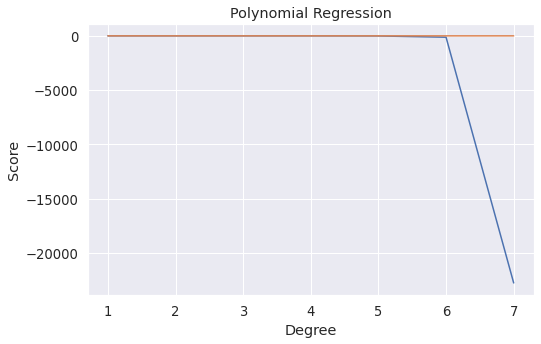

In [53]:
plt_data(score_lst, test_lst, 'Score')
plt_data(score_lst, train_lst, 'Score')

- Second degree still has the best scores for validation and testing 
- By increasing degree overfitting increased

In [54]:
# ==== With Ridge Regulization ====
ridge_model = Ridge(alpha=30)
score_lst, train_lst, test_lst = reg_cross_val(ridge_model, 8, 10)

Degree ==>>  1
Train Score : 0.7099121361258505
Test Score  : 0.6889063787282993


Degree ==>>  2
Train Score : 0.7533282282069759
Test Score  : 0.7339070112712851


Degree ==>>  3
Train Score : 0.7505182082177176
Test Score  : 0.7237495496228518


Degree ==>>  4
Train Score : 0.7478392515566838
Test Score  : 0.7136430447364092


Degree ==>>  5
Train Score : 0.753596560060077
Test Score  : 0.7212897719399268


Degree ==>>  6
Train Score : 0.76618716544564
Test Score  : 0.6933249126084883


Degree ==>>  7
Train Score : 0.7691343453733501
Test Score  : 0.7330522720711995




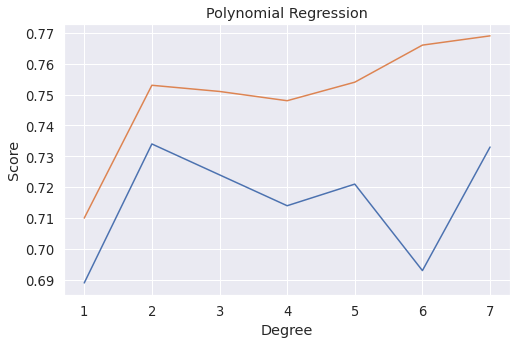

In [55]:
plt_data(score_lst, test_lst, 'Score')
plt_data(score_lst, train_lst, 'Score')

- Second degree has the highest testing score also in training more generalized

---------------------------------------------------------------------------------------------------------------

<b> Questions: </b>

1- Which polynomial degree gave the best generalization on the test set based on your observations on the validation set? Are there several polynomial degrees giving the same results?

- Second degree has the highest testing score also in training more generalized

- Degree ==>>  2
- Train Score : 0.7533282282069759
- Test Score  : 0.7339070112712851

- Second and seventh degrees test scores are close to each others
- Degree 2 (Test Score)  =  0.7339
- Degree 7 (Test Score)  =  0.7330

---------------------------------------------------------------------------------------------------------------

2- Are there any benefits from using cross-validation this time compared to the hold-out method in problem1? Mention them.

- By using hold-out method we just only have one part for testing and may be it bised, but throgth using k-fold cross-validation we have many different test splits generated from main dataset each time during tarining and testing, so we can validate the score of our model by taking the mean of all folds, also it is more effecient when the dataset is not big enough.

---------------------------------------------------------------------------------------------------------------

3- If we assumed that we have a dataset for different car manufacturer and we want to reach a model that can be good in predicting even new car that is from unknown (unseen) manufacturer? Would you suggest what to do in training and cross-validation to make sure of having such case?

- By using same preprocessing including same feature scaling type, using same model with final best hyper parameters and regulization method, as in our case we find that polynomial of second degree using Ridge regulization specially by alpha equal to 30 get the best scores, and finally use the same K-Fold for data spliting as in our case we use 10 k-fold.